## Pneumonic plague model for Barcelona 1490

#### Import packages

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
#from pymc.Matplot import plot
import scipy.stats

#### Import observed data

In [2]:
london = np.array([2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 4, 3, 4, 5, 5, 7, 9, 10, 11, 14, 14, 17, 17, 19, 20, 20, 21, 23, 23, 25, 27, 29, 30, 32, 35, 39, 41, 45, 49, 53, 57, 63, 67, 72, 78, 84, 89, 94, 100, 105, 110, 114, 118, 122, 128, 139, 150, 165, 184, 204, 226, 246, 261, 272, 279, 282, 281, 276, 275, 276, 282, 290, 303, 319, 337, 359, 381, 405, 431, 457, 486, 514, 538, 556, 569, 575, 577, 572, 565, 563, 572, 588, 616, 651, 696, 747, 797, 842, 882, 917, 947, 974, 994, 1008, 1015, 1014, 1007, 992, 970, 943, 924, 915, 916, 927, 948, 980, 1016, 1043, 1055, 1054, 1037, 1006, 961, 904, 854, 811, 775, 749, 730, 721, 716, 714, 711, 706, 701, 696, 689, 680, 668, 651, 628, 601, 568, 531, 488, 449, 411, 376, 344, 313, 287, 261, 238, 218, 199, 182, 169, 156, 146, 139, 138, 140, 145, 155, 169, 184, 199, 206, 211, 211, 206, 197, 183, 171, 159, 148, 138, 129, 122, 114, 107, 101, 93, 86, 79, 72, 64, 57, 52, 46, 41, 38, 36, 32, 31, 30, 29, 29, 29, 31, 31, 33, 33, 35, 36, 37, 38, 38, 38, 40, 40, 41, 41, 43])
mortality_data = london
t = len(mortality_data)

#### Set up the model

In [3]:
__all__ = ['mortality_data','beta', 'gamma', 
           'S_0', 'I_0', 'D_0', 'D', 'D_h', 'mortality', 
           'pop_size', 'sus_frac', 'mortality_sim']

#Parameters
beta = pm.Uniform('beta', 1e-9, 1.0)
gamma = .4

sus_frac = pm.Uniform('sus_frac', 1e-9, 1.)
pop_size = 25000.

#Intial conditions
S_0 = pop_size*sus_frac
I_0 = pm.Uniform('I_0', 1., 10.)
D_0 = 1.

#SID model for pneumonic plague
@pm.deterministic
def SID(S_0=S_0, I_0=I_0, D_0=D_0, beta=beta, gamma=gamma):
    S = np.zeros(t)
    I = np.zeros(t)
    D = np.zeros(t)

    S[0] = S_0
    I[0] = I_0
    D[0] = D_0
    
    for i in range(1, t):
        new_infected = min(S[i-1], beta*S[i-1]*I[i-1]/(S[i-1]+I[i-1]))
        new_dead = min(I[i-1], gamma*I[i-1])
        
        S[i] = S[i-1] - new_infected
        I[i] = I[i-1] + new_infected - new_dead
        D[i] = new_dead

    return S, I, D

D_h = pm.Lambda('D_h', lambda SID=SID: SID[2])

#Likelihood
mortality = pm.Poisson('mortality', mu=D_h, value=mortality_data, observed=True)
mortality_sim = pm.Poisson('mortality_sim', mu=D_h)

#### Fit the model

In [4]:
if __name__ == '__main__':
    vars = [mortality_data, beta, gamma, 
            S_0,I_0, D_0, D_h, mortality, 
            pop_size, sus_frac, mortality_sim]
    
    mc = pm.MCMC(vars, db='pickle', dbname='pneu')
    mc.use_step_method(pm.AdaptiveMetropolis, [beta, sus_frac, I_0])
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.db.close()

 [                  0%                  ] 1151 of 180000 complete in 2.5 sec

/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/pymc/StepMethods.py:1282: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 180000 of 180000 complete in 125.9 sec

#### Output summary

In [ ]:
pm.gelman_rubin(mc)

In [ ]:
mc.summary()

In [5]:
M = pm.MAP(mc)
M.fit()
M.BIC

/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


79384.75195708266

#### Plot the posteriors

In [6]:
%matplotlib inline
plot(mc)

NameError: name 'plot' is not defined

#### Plot the fit

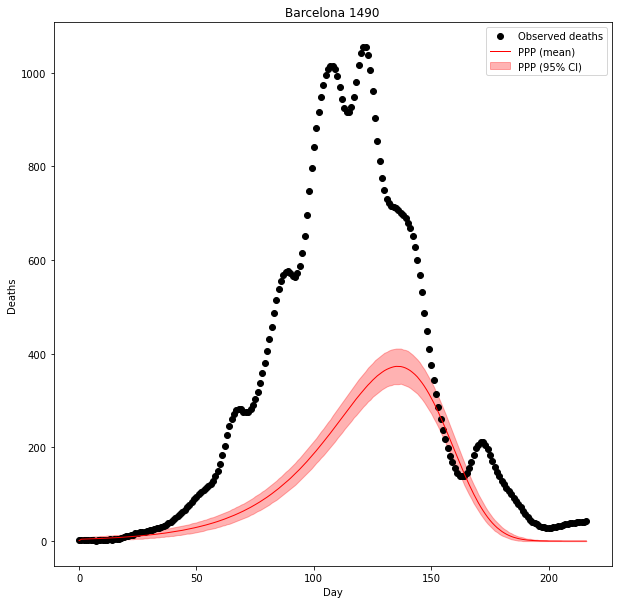

In [7]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title('Barcelona 1490')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.plot(mortality_data, 'o', mec='black', color='black', label='Observed deaths')
plt.plot(mortality_sim.stats()['mean'], color='red', linewidth=1, label='PPP (mean)')
y_min = mortality_sim.stats()['quantiles'][2.5]
y_max = mortality_sim.stats()['quantiles'][97.5]
plt.fill_between(range(0,len(mortality_data)), y_min, y_max, color='r', alpha=0.3, label='PPP (95% CI)')
plt.legend()